In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import correlate, hilbert
# pip install jcamp
from jcamp import jcamp_readfile

methanol_data = jcamp_readfile('data/methanol_IR.jdx')
methanol_wavenumbers = methanol_data['x']
methanol_absorbance = methanol_data['y']
print("Length of methanol data: ", len(methanol_wavenumbers))
print("Wavenumber interval of methanol: ", round((methanol_wavenumbers[-1] - methanol_wavenumbers[0])/len(methanol_wavenumbers),3))

ethanol_data = jcamp_readfile('data/ethanol_IR.jdx')
ethanol_wavenumbers = ethanol_data['x']
ethanol_absorbance = ethanol_data['y']
print("Length of ethanol data: ", len(ethanol_wavenumbers))
print("Wavenumber interval of ethanol: ", round((ethanol_wavenumbers[-1] - ethanol_wavenumbers[0])/len(ethanol_wavenumbers),3))

def resample_timeseries(x1, y1, x2, y2, samples=None):
    if samples is None:
        samples = int(0.5 * (len(x1) + len(x2)))
    # Define the common set of x values as the union of x1 and x2
    x_min = max(min(x1), min(x2))
    x_max = min(max(x1), max(x2))
    x = np.linspace(x_min, x_max, samples)

    # Interpolate y1 and y2 onto the common set of x values
    f1 = interp1d(x1, y1, kind='linear')
    f2 = interp1d(x2, y2, kind='linear')

    return x, f1(x), f2(x)

resampled_data = resample_timeseries(methanol_wavenumbers, methanol_absorbance, ethanol_wavenumbers, ethanol_absorbance)
wavenumbers = resampled_data[0]
methanol_absorbance_resampled = resampled_data[1]
ethanol_absorbance_resampled = resampled_data[2]
print("Length of resampled data: ", len(wavenumbers))
print("Min wavenumber: ", min(wavenumbers), "Max wavenumber: ", max(wavenumbers))

Length of methanol data:  3567
Wavenumber interval of methanol:  0.937
Length of ethanol data:  3570
Wavenumber interval of ethanol:  0.937
Length of resampled data:  3568
Min wavenumber:  463.438 Max wavenumber:  3806.57


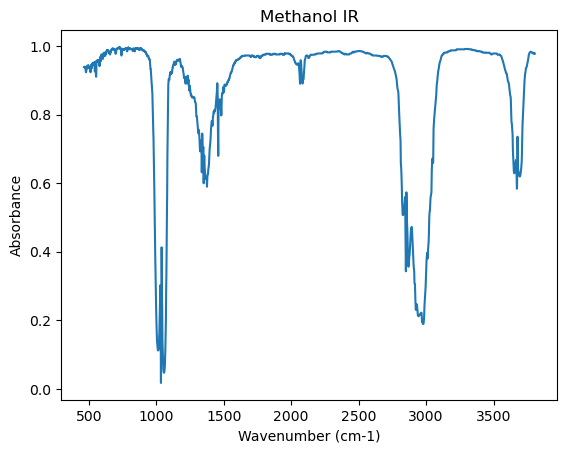

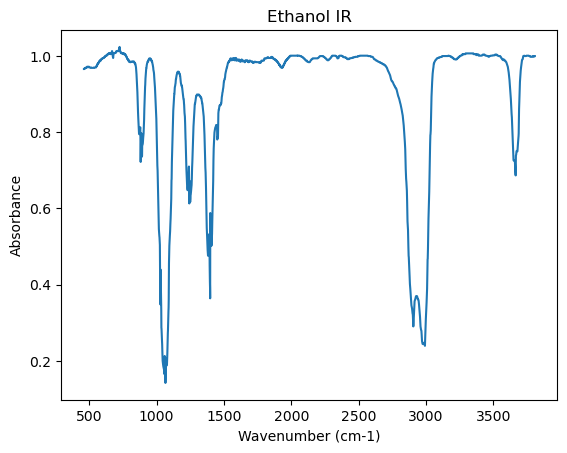

In [32]:
plt.plot(methanol_wavenumbers, methanol_absorbance)
plt.title('Methanol IR')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Absorbance')
plt.show()

plt.plot(ethanol_wavenumbers, ethanol_absorbance)
plt.title('Ethanol IR')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Absorbance')
plt.show()

## Normalised Cross Correlation

In [48]:
def cross_correlation(y1, y2):
    """
    Compute the cross-correlation between two time series with the same sampling interval.
    """
    # We do this for valid lags (those smaller than the difference between the lengths of the two time series)
    cross_corr = correlate(y1, y2, 'valid')
    optimal_lag = np.argmax(cross_corr)
    maximum_cross_correlation = np.max(cross_corr)

    return maximum_cross_correlation, optimal_lag


def normalised_cross_correlation(y1, y2):
    """
    Compute the normalised cross-correlation between two time series with the same sampling interval.
    """
    maximum_cross_correlation, optimal_lag = cross_correlation(y1, y2)
    norm_corr = maximum_cross_correlation / (np.sqrt(np.sum(y1**2)) * np.sqrt(np.sum(y2**2)))

    return norm_corr, optimal_lag

ncc = normalised_cross_correlation(methanol_absorbance_resampled, ethanol_absorbance_resampled)

print("Normalised cross-correlation: ", ncc[0])
print("Optimal lag: ", ncc[1])

Normalised cross-correlation:  0.9932267039124398
Optimal lag:  0


## RMSD Integrated Spectra

In [55]:
def rmsd(y1, y2, lag=None):
    """
    Compute the root-mean-square deviation between two time series with the same sampling interval.
    """
    if lag is None:
        _, optimal_lag = cross_correlation(y1, y2)
    else:
        optimal_lag = lag

    y_diff = y1 - np.roll(y2, optimal_lag)
    y_diff_sq = y_diff**2
    mean_diff_sq = np.mean(y_diff_sq)
    RMSD = np.sqrt(mean_diff_sq)

    return RMSD, optimal_lag

spec_rmsd = rmsd(methanol_absorbance_resampled, ethanol_absorbance_resampled)

print("RMSD: ", spec_rmsd[0])
print("Optimal lag: ", spec_rmsd[1])

RMSD:  0.10851336023993642
Optimal lag:  0


## Distance Separation of Fourier Transform

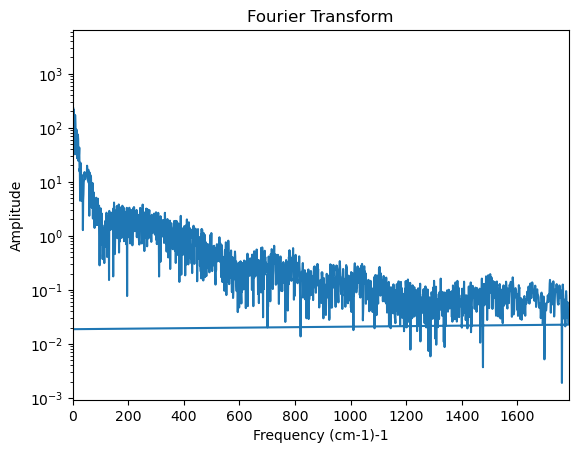

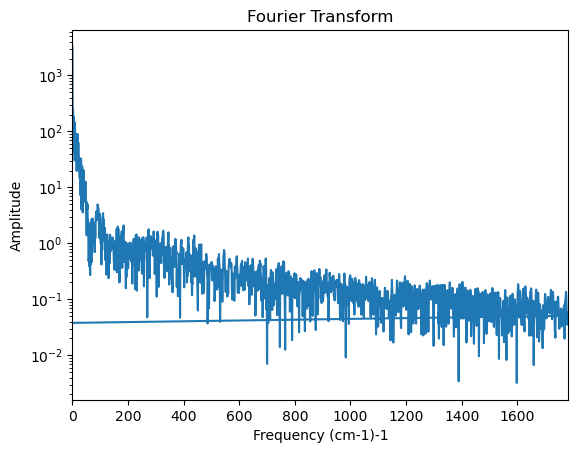

FFT RMSD 4.08087766645278


In [57]:
def fft_plot(y):
    y_fft = np.fft.fft(y)
    freqs = np.fft.fftfreq(len(y))*len(y)

    fig, ax = plt.subplots()
    ax.plot(freqs, np.abs(y_fft))
    ax.set_yscale('log')
    ax.set_xlabel('Frequency (cm-1)-1')
    ax.set_ylabel('Amplitude')
    ax.set_title('Fourier Transform')
    # Set x-limits to the range between 0 and the Nyquist frequency
    ax.set_xlim(0, 0.5 * len(y))

    plt.show()

    return freqs, np.abs(y_fft)


_, methanol_fft = fft_plot(methanol_absorbance_resampled)
_, ethanol_fft = fft_plot(ethanol_absorbance_resampled)

fft_rmsd = rmsd(methanol_fft, ethanol_fft, lag=0)
print("FFT RMSD", fft_rmsd[0])

[0.12003459 0.67680839 0.69249635 0.09505059 0.43427405 0.44544707
 0.59179935 0.95552712 0.21711326 0.57173719 0.88165831 0.0104638
 0.76526639 0.33149233 0.48006656 0.788505   0.79276849 0.02048193
 0.45580386 0.32283103 0.11666428 0.3695887  0.22847019 0.78000092
 0.75763079 0.96835624 0.74385639 0.89854181 0.05201287 0.98597359
 0.6251274  0.86343041 0.70695877 0.1382904  0.7100809  0.1637735
 0.28509878 0.89247081 0.901149   0.07868438 0.12973895 0.59399777
 0.47840837 0.19244822 0.64204765 0.51993623 0.15107667 0.55858224
 0.68288727 0.79353266 0.16274487 0.83552125 0.7310469  0.06206662
 0.20956399 0.43943704 0.00780551 0.62661234 0.61783579 0.50624093
 0.62574415 0.69844482 0.40438245 0.33008274 0.50738831 0.28989658
 0.31246691 0.53969242 0.09979805 0.33005296 0.24697865 0.26562493
 0.44459035 0.13896487 0.99975237 0.71924437 0.87218158 0.76645276
 0.23031549 0.51295018 0.56756949 0.33499236 0.29988123 0.32226828
 0.62624194 0.82942127 0.7276466  0.12744658 0.35405756 0.332281

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (100,) (3568,) 

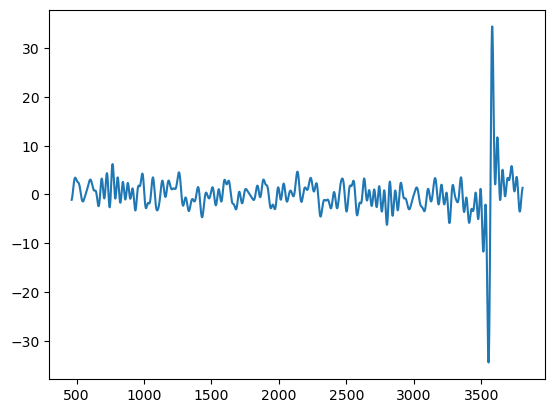

In [13]:
import numpy as np
import autograd.numpy as ag_np  
from autograd import grad
from tqdm import tqdm

num_coeff = 100
a = np.random.rand(num_coeff)
L = 3568
x_array = wavenumbers
g_array = methanol_absorbance_resampled

def f(a):
    return np.sum([a[i] * ag_np.sin(2*ag_np.pi*i*x_array/L) for i in range(num_coeff)], axis=0)

plt.plot(x_array, f(a))

def rmsd(f,g):
    return ag_np.sqrt(ag_np.mean((f-g)**2))

# Define the gradient of the RMSD function using autograd
grad_rmsd = grad(rmsd)

# Run the gradient descent loop
for i in tqdm(range(100)):
    f_a = f(a)
    # Compute the gradient of the RMSD function with respect to the coefficients a
    grad_a = grad_rmsd(f_a,g_array)
    # Update the coefficients using the gradient and a learning rate of 0.01
    a = a - 0.01 * grad_a
    
plt.plot(x_array, f(a))
